In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle
from datetime import datetime
import json

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torchinfo import summary

from utils import (load_all_data, 
                   squeeze_and_concat, 
                   filter_mask_keep_labels, 
                   multiclass_dice_loss, 
                   check_gradients)
from datasets import MultiTissueDataset
from unet_advanced import UNetAdvanced as UNetGan
from gan_basic import DiscriminatorModel
from train_utils import EarlyStopping, save_checkpoint

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left
data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

In [4]:
val_fraction = 0.2

num_samples = len(data_concat['input_labels'])
indices = np.arange(num_samples)
np.random.shuffle(indices)

train_indices = indices[:int(num_samples*(1-val_fraction))]
val_indices = indices[int(num_samples*(1-val_fraction)):]

In [5]:
train_data = {key: value[train_indices] for key, value in data_concat.items()}
val_data = {key: value[val_indices] for key, value in data_concat.items()}

In [6]:
train_dataset = MultiTissueDataset(train_data)
val_dataset = MultiTissueDataset(val_data)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
def train_discriminator(batch, gen, discr, criterion_GAN, optim_discr, device='cpu'):
    input = batch['input_label'].to(device) # Models passed to the function should be already on the same device
    gt = batch['multiClassMask'].to(device)

    # train discriminator
    with torch.no_grad():
        gen_img_probs = gen(input).softmax(dim=1)  # Get probabilities for each class

    gt_onehot = torch.zeros_like(gen_img_probs).scatter_(1, gt.unsqueeze(1), 1.0) # Assigns 1.0 in the corresponding class channel based on gt indices (0-11)

    discr_input_real = torch.cat([input, gt_onehot], dim=1)  # Real pairs: input + gt
    discr_input_fake = torch.cat([input, gen_img_probs], dim=1)  # Fake pairs: input + generated segmentation (probs)

    discr_real = discr(discr_input_real) # Discrim forward pass on real pairs
    discr_fake = discr(discr_input_fake) # Discrim forward pass on fake pairs

    loss = criterion_GAN(discr_real, torch.ones_like(discr_real)) + \
        criterion_GAN(discr_fake, torch.zeros_like(discr_fake))

    optim_discr.zero_grad()
    loss.backward()
    optim_discr.step()

    return loss.item()

def train_generator(batch, gen, discr, criterion_GAN, criterion_CE, optim_gen, lambda_ce, device='cpu'):
    input = batch['input_label'].to(device)
    gt = batch['multiClassMask'].to(device)
    
    gen_img = gen(input)
    gen_img_probs = gen_img.softmax(dim=1)  # Now with gradients enablesd for generator training

    discr_input_fake = torch.cat([input, gen_img_probs], dim=1)  # Fake pairs: input + generated segmentation (probs)
    discr_fake = discr(discr_input_fake) # Discrim forward pass on fake pairs


    ce_loss = criterion_CE(gen_img, gt)  # CE loss between generated segmentation and ground truth (B, 12, H, W)
    loss_gen = criterion_GAN(discr_fake, torch.ones_like(discr_fake)) + lambda_ce * ce_loss

    optim_gen.zero_grad()
    loss_gen.backward()
    optim_gen.step()

    return loss_gen.item(), ce_loss.item()

def validate_generator(val_dataloader, gen, discr, criterion_GAN, criterion_CE, lambda_ce, device='cpu'):
    gen.eval()
    discr.eval()

    total_gan_loss = 0.0
    total_ce_loss = 0.0
    total_dice_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input = batch['input_label'].to(device)
            gt = batch['multiClassMask'].to(device)

            gen_img = gen(input)
            gen_img_probs = gen_img.softmax(dim=1)

            discr_input_fake = torch.cat([input, gen_img_probs], dim=1)
            discr_fake = discr(discr_input_fake)

            # Compute losses
            ce_loss = criterion_CE(gen_img, gt)
            gan_loss = criterion_GAN(discr_fake, torch.ones_like(discr_fake))
            dice_loss = multiclass_dice_loss(gen_img, gt) # Logits here as input

            total_gan_loss += gan_loss.item()
            total_ce_loss += ce_loss.item()
            total_dice_loss += dice_loss.item()
            num_batches += 1

    avg_gan_loss = total_gan_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_dice_loss = total_dice_loss / num_batches

    return avg_gan_loss, avg_ce_loss, avg_dice_loss


In [ ]:
def train_gan(num_steps, n_discr_steps, val_check_interval, gen, discr, dataloader, criterion_GAN, criterion_CE, optim_gen, optim_discr, lambda_ce, es, device, exp_dir):
    inf_iter = cycle(dataloader)
    pbar = tqdm(range(num_steps), desc="Training step")
    
    metrics_history = {
        'train_D_loss': [],
        'train_G_loss': [],
        'train_CE_loss': [],
        'val_G_loss': [],
        'val_CE_loss': [],
        'val_Dice_loss': [],
        'current_step': 0.0
    }

    for step in pbar:
        batch = next(inf_iter)

        gen.train()
        discr.train()

        loss_discr = 0.0
        for _ in range(n_discr_steps): # Nested loop to allow multiple discriminator updates per generator update
            running_loss_discr = train_discriminator(batch, gen, discr, criterion_GAN, optim_discr, device)
            loss_discr += running_loss_discr
        loss_discr /= n_discr_steps
    
        loss_gen, ce_loss = train_generator(batch, gen, discr, criterion_GAN, criterion_CE, optim_gen, lambda_ce, device)

        metrics_history['train_D_loss'].append(loss_discr)
        metrics_history['train_G_loss'].append(loss_gen)
        metrics_history['train_CE_loss'].append(ce_loss)
        metrics_history['current_step'] = step

        if step % val_check_interval == 0 and step > 0: # Validate every val_check_interval steps
            val_gan_loss, val_ce_loss, val_dice_loss = validate_generator(val_dataloader, gen, discr, criterion_GAN, criterion_CE, lambda_ce, device)
            metrics_history['val_G_loss'].append(val_gan_loss)
            metrics_history['val_CE_loss'].append(val_ce_loss)
            metrics_history['val_Dice_loss'].append(val_dice_loss)

            # Save checkpoint
            save_checkpoint(exp_dir, step, gen, discr, optim_gen, optim_discr, metrics_history)

            # check for early stopping based on validation dice score
            es.check_early_stop(1-val_dice_loss)
            if es.no_improvement_count == 0 and step > 0: # Save best model based on validation dice score
                torch.save(gen.state_dict(), f"{exp_dir}/best_generator.pth")
            if es.stop_training:
                print(f"Early stopping triggered at step {step}.")
                break
        
        if step % 20 == 0: # Update progress bar every 20 steps
            pbar.set_postfix({
                'train_D_loss': f'{loss_discr:.4f}', 
                'train_G_loss': f'{loss_gen:.4f}',
                'train_CE_loss': f'{ce_loss:.4f}',
                'val_G_loss': f'{val_gan_loss:.4f}' if step >= val_check_interval else 'N/A',
                'val_CE_loss': f'{val_ce_loss:.4f}' if step >= val_check_interval else 'N/A',
                'val_Dice_loss': f'{val_dice_loss:.4f}' if step >= val_check_interval else 'N/A'
            })
    
    # Save metrics history to a JSON file
    with open(f"{exp_dir}/metrics_history.json", "w") as f:
        json.dump(metrics_history, f, indent=4)

    return metrics_history

        

In [ ]:
run_name = "MT_basic_gan"
timestpamp = datetime.now().strftime("%Y%m%d_%H%M")
exp_dir = f"./experiments/{timestpamp}_{run_name}"
os.makedirs(exp_dir, exist_ok=True)


num_steps = 2000
n_discr_steps = 1
lambda_ce = 10.0

val_check_interval = 120  # Check validation performance every 120 steps (approx every dataset epoch)

gen = UNetGan(in_ch=4, num_classes=12, dropout_p=0.3).to(device)
discr = DiscriminatorModel(in_ch=16, base_ch=64).to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_CE = nn.CrossEntropyLoss() # CE loss for segmentation (better than L1 for classification tasks)

optim_gen = optim.Adam(gen.parameters(), lr=1e-4)
optim_discr = optim.Adam(discr.parameters(), lr=1e-4)

es = EarlyStopping(patience=10, delta=0.01)  # Early stopping based on validation Dice score

In [30]:
config = {
    'num_steps': num_steps,
    'n_discr_steps': n_discr_steps,
    'lambda_ce': lambda_ce,
    'val_check_interval': val_check_interval,
    'batch_size': train_dataloader.batch_size,
    'learning_rate_gen': optim_gen.param_groups[0]['lr'],
    'learning_rate_discr': optim_discr.param_groups[0]['lr'],
    'notes': "basic GAN training with UNet generator and simple discriminator"
}

with open(f"{exp_dir}/config.json", "w") as f:
    json.dump(config, f, indent=4)

In [ ]:
history = train_gan(num_steps, n_discr_steps, val_check_interval, gen, discr, train_dataloader, criterion_GAN, criterion_CE, optim_gen, optim_discr, lambda_ce, es, device)

Training step: 100%|██████████| 2000/2000 [20:44<00:00,  1.61it/s, train_D_loss=0.4985, train_G_loss=5.5640, train_CE_loss=2.9172] 


In [14]:
# check on generated images
with torch.no_grad():
    val_batch = next(iter(val_dataloader))
    input = val_batch['input_label'].to(device)
    gt = val_batch['multiClassMask'].to(device)
    gen_img = gen(input)



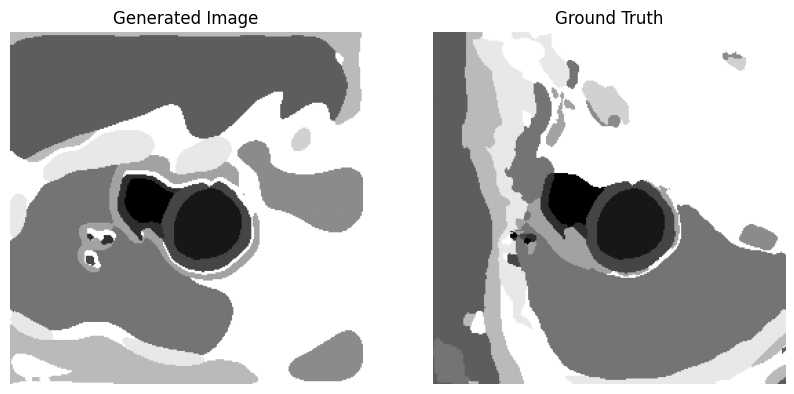

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(torch.argmax(gen_img[2], dim=0).cpu(), cmap='gray')
ax[0].set_title("Generated Image")
ax[0].axis("off")

ax[1].imshow(gt[2].cpu(), cmap='gray')
ax[1].set_title("Ground Truth")
ax[1].axis("off")

plt.show()

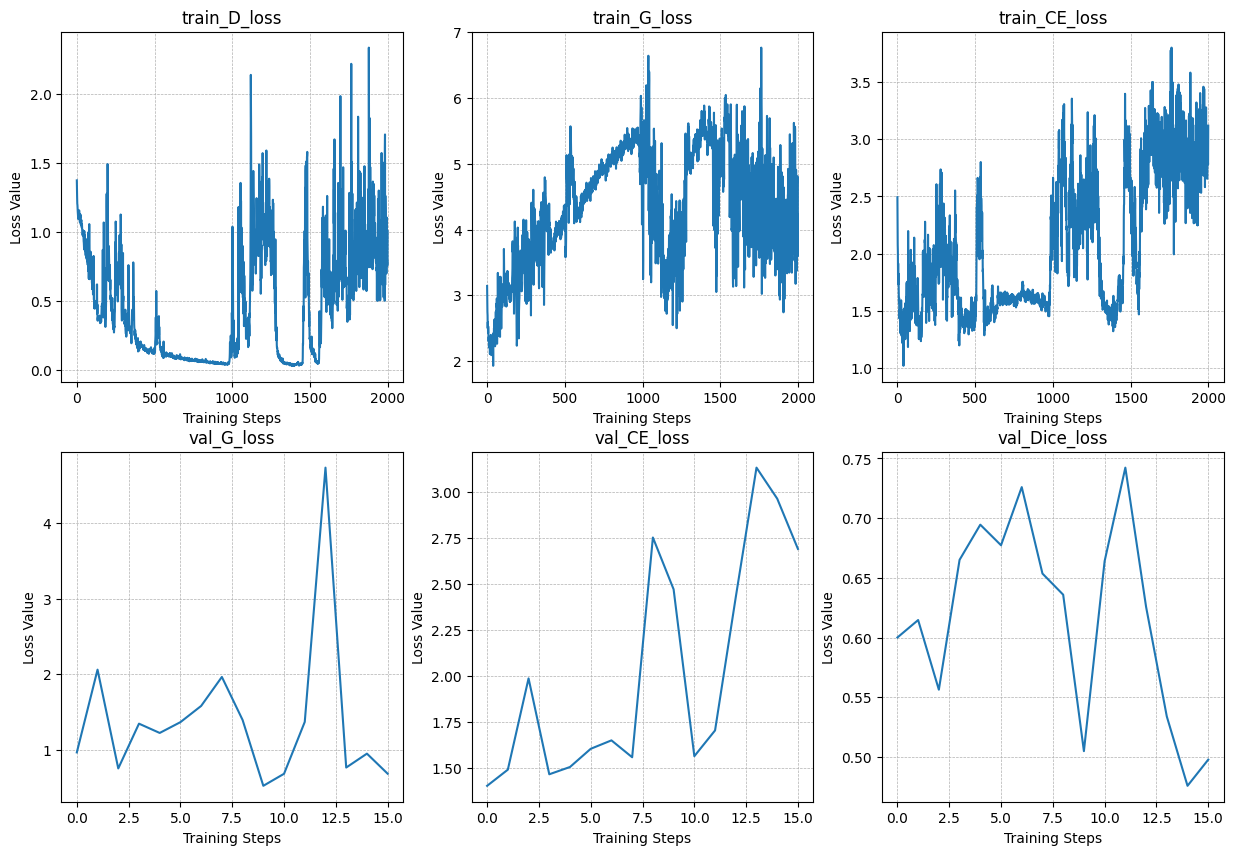

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i, key in enumerate(history.keys()):
    ax[i].plot(history[key])
    ax[i].set_title(list(history.keys())[i])
    ax[i].set_xlabel("Training Steps")
    ax[i].set_ylabel("Loss Value")
    ax[i].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
torch.save(gen.state_dict(), "./models/gan_texturizer_basic_gan_model.pth")